In [68]:
# Импортируем необходимые библиотека
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [69]:
# Подгразим данные и посмотрим на то, как выглядит датасет

df = pd.read_csv('tea_demand.zip', sep='\t')
df

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
...,...,...,...
454,178,2016-11-29,222
455,29,2016-11-29,1173
456,5152,2016-11-30,311
457,178,2016-11-30,227


In [70]:
df['timestamp'] = pd.to_datetime(df['date'])

In [71]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['Month'] = df['timestamp'].dt.month
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [72]:
# Разделим продукты по своим датасетам и посмотрим на визуализацию рядов

df_id = {}
for id in df['brand_id'].unique():
    df_id[id] = df[df['brand_id'] == id].copy()

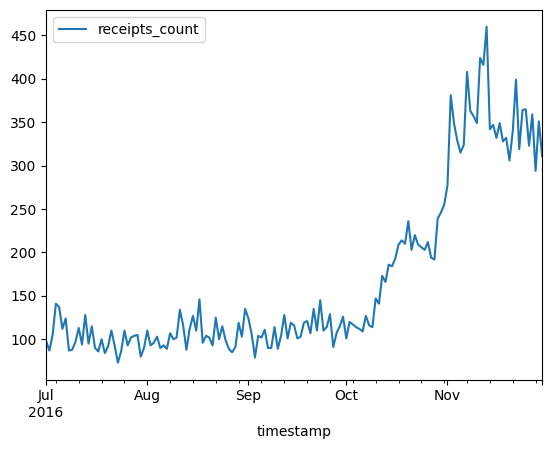

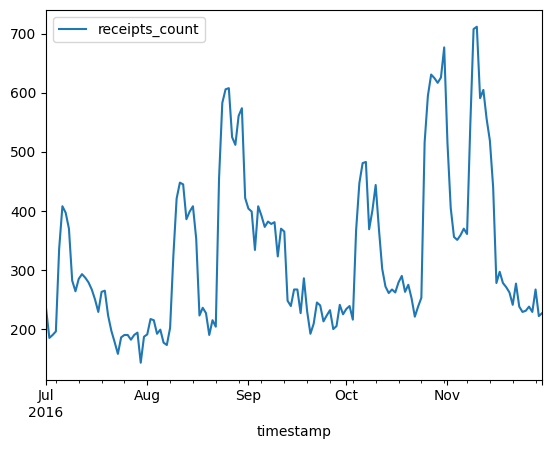

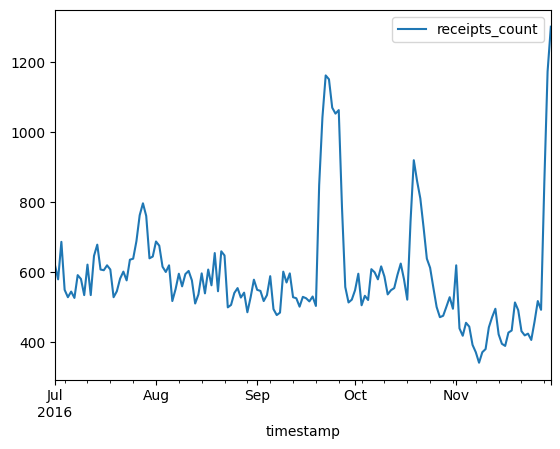

In [73]:
for id in df_id.values():
    id.plot(x='timestamp', y='receipts_count')

In [74]:
data = df[['brand_id', 'receipts_count', 'DayOfTheWeek', 'Month', 'WeekDay']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

c:\Users\saakyan.ag\AppData\Local\pypoetry\Cache\virtualenvs\sales-web-service-kfQHbaDz-py3.12\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\saakyan.ag\AppData\Local\pypoetry\Cache\virtualenvs\sales-web-service-kfQHbaDz-py3.12\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\saakyan.ag\AppData\Local\pypoetry\Cache\virtualenvs\sales-web-service-kfQHbaDz-py3.12\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_par

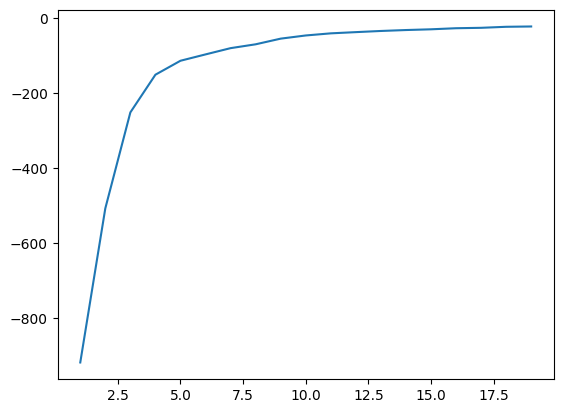

In [75]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
#TODO давайте подберем оптимальное число кластеров k-means
#TODO обучить KMeans для заданных числе кластеров
#TODO как подобрать число кластеров?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [76]:
df['cluster'] = kmeans[3].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

cluster
0    218
2    109
1     86
3     46
Name: count, dtype: int64

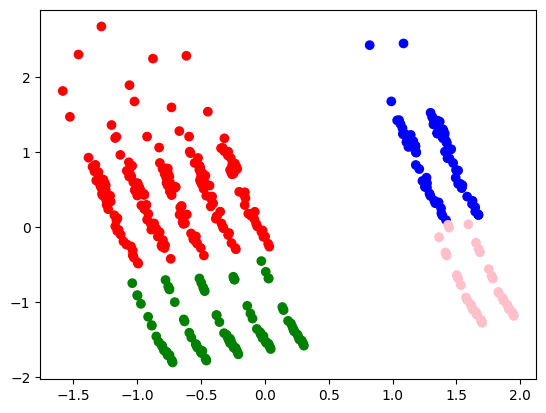

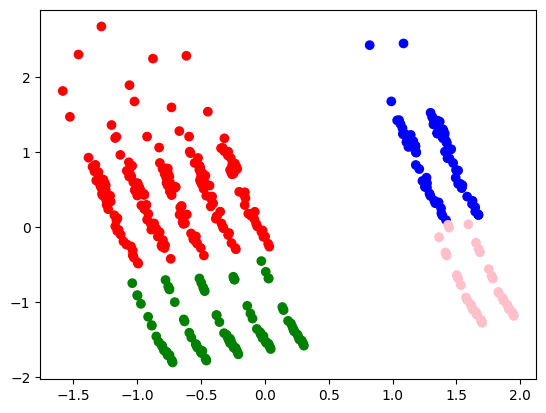

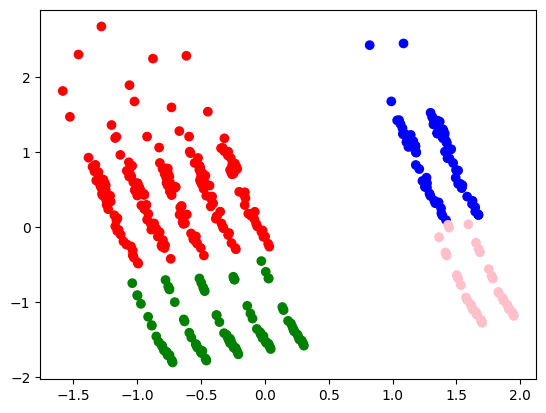

In [77]:
for id in df_id.values():
    fig, ax = plt.subplots()
    colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
    ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
    plt.show()

In [78]:
def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)    
    return distance

In [79]:
outliers_fraction = 0.01
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)


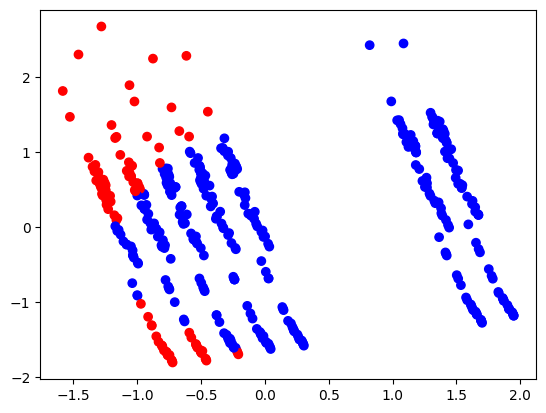

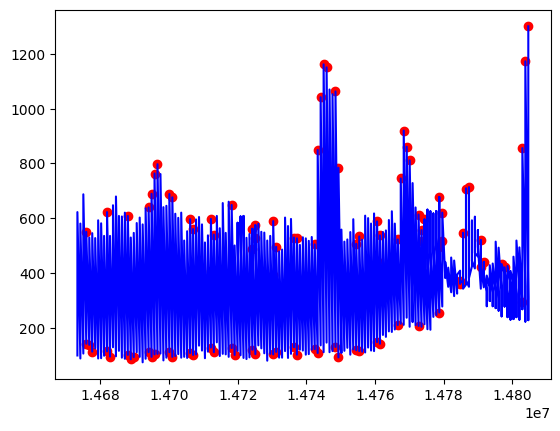

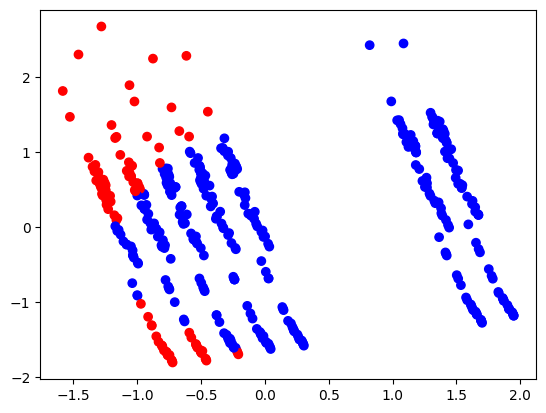

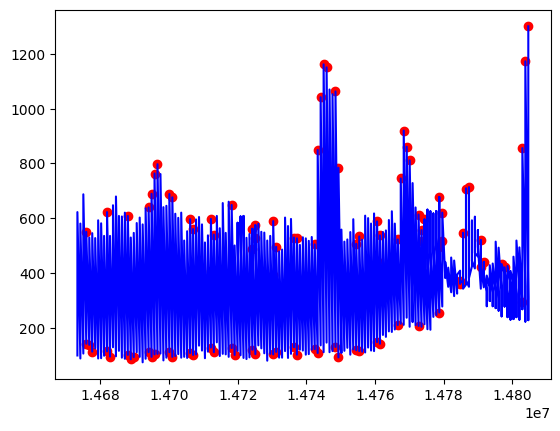

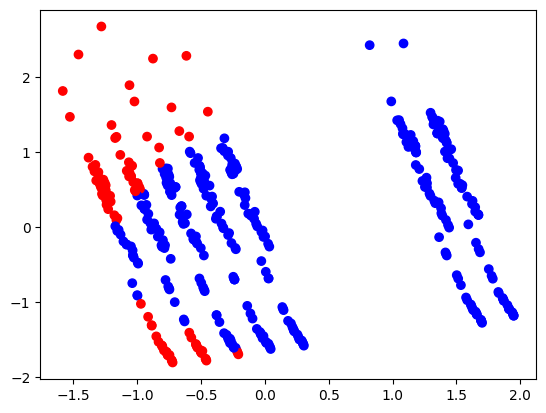

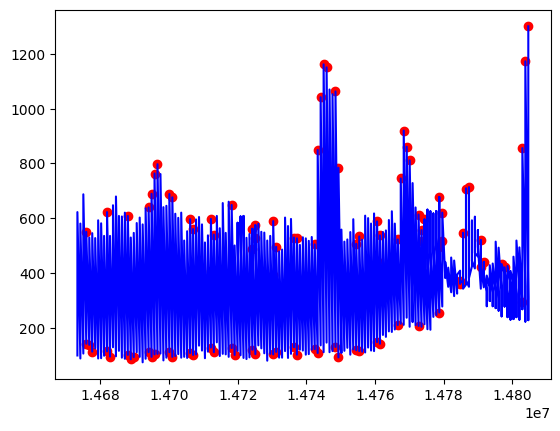

In [80]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

for id in df_id.values():
    # Считаем точку аномалией, если расстояние до центра кластера больше порога
    df['anomaly21'] = (distance >= 3.0).astype(int)

    fig, ax = plt.subplots()
    colors = {0:'blue', 1:'red'}
    ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
    plt.show()

    fig, ax = plt.subplots()

    a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'receipts_count']] #anomaly

    ax.plot(df['time_epoch'], df['receipts_count'], color='blue')
    ax.scatter(a['time_epoch'],a['receipts_count'], color='red')
    plt.show()

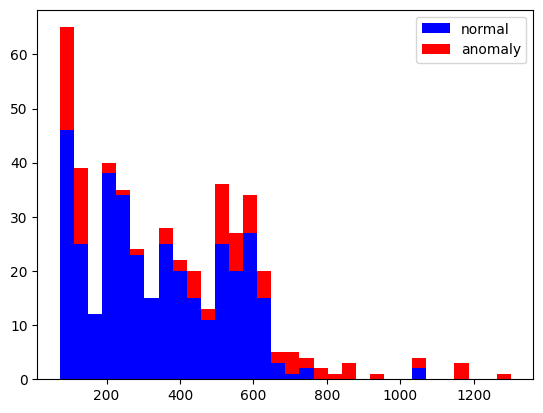

In [81]:
# Посмотрим на распределение аномальных и действительных значений
a = df.loc[df['anomaly21'] == 0, 'receipts_count']
b = df.loc[df['anomaly21'] == 1, 'receipts_count']
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

<Axes: xlabel='DayOfTheWeek', ylabel='receipts_count'>

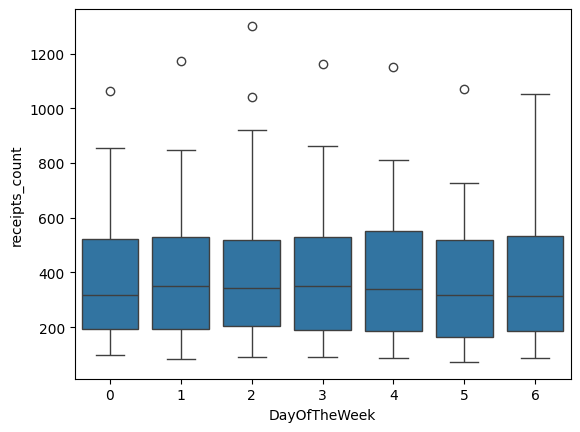

In [82]:
seaborn.boxplot(df, y=df['receipts_count'], x=df['DayOfTheWeek'])

Выводы:

Из всех привиденных визуализаций видно, что проведенная компани никак не повлияла на продажи, а найденные аномилии не имеют ярко выраженной закономерноски не по одному из брендов.